# Fig 2B: Proportion of non-linearities of GDSC-to-PDXE consensus features
This notebook supports Fig_2B of the manuscript.

In [38]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import scipy
from datetime import date
sns.set_style("whitegrid")
sns.set_context('paper')
from matplotlib import font_manager as fm, rcParams
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/arial.ttf")
prop_label = fm.FontProperties(fname=fpath)
prop_label.set_size(30)
prop_ticks = fm.FontProperties(fname=fpath)
prop_ticks.set_size(25)
fname = os.path.split(fpath)[1]

from sklearn.preprocessing import StandardScaler

sys.path.insert(0, '../read_data/')
from read_data import read_data
from reformat_df import reformat_df
import library_size_normalization

from transact.pv_computation import PVComputation
from transact.interpolation import Interpolation
from transact.matrix_operations import _center_kernel, _right_center_kernel, _left_center_kernel
from transact.kernel_computer import KernelComputer
from transact.PRECISE import TRANSACT

from compute_proportion import compute_proportion

In [2]:
# da: domain adaptation
tissues = {
    'PDXE': ['All'],
    'GDSC': ['All']
}
projects = {
    'PDXE':[None],
    'GDSC': None
}

data_sources = ['GDSC', 'PDXE']

data_types = ['fpkm']
genes_filtering = 'mini'
data_normalization = 'library_size' # Can be TPM, "library_size" or "log". Else will not have any influence.

source = 'GDSC'
target = 'PDXE'

## Read data

In [3]:
data_df = read_data(tissues=tissues,
                    data_types=[e for e in data_types],
                    projects=projects,
                    data_sources=data_sources,
                    folder_basis='../data/')

source_data_key, target_data_key = reformat_df(data_df, source, target)

DATA UPLOADED
GENE HARMONIZED ACROSS VIEWS
CHECKED FOR GOOD HARMONIZATION


In [4]:
# Library size normalization
average_depth_global = 10**5
for ds in list(data_df.keys()):
    GE_normalized = library_size_normalization.TMM_normalization(data_df[ds].values.astype(float))
    GE_normalized = np.array(GE_normalized)
    average_depths = np.mean(np.sum(GE_normalized,1))
    GE_normalized = GE_normalized / average_depths * average_depth_global
    GE_normalized = np.log(np.array(GE_normalized)+1)
    data_df[ds] = pd.DataFrame(GE_normalized,
                               columns=data_df[ds].columns,
                               index=data_df[ds].index)

In [5]:
# Normalization
with_mean = True
with_std = True

normalized_data_df = {
    ds : StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(data_df[ds])
    for ds in data_df
}

## Computing contribution of each component

In [6]:
number_pc = {
    'source': 70,
    'target': 50
}

n_pv = 20

In [7]:
gamma_values = np.logspace(-6,-2,20,base=10)

contribution = {gamma:compute_proportion(gamma,
                                         number_pc,
                                         n_pv,
                                         normalized_data_df,
                                         source_data_key,
                                         target_data_key) for gamma in gamma_values}
clf = {gamma:contribution[gamma][0] for gamma in gamma_values}
contribution = {gamma:contribution[gamma][1] for gamma in gamma_values}

FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    6.1s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.5s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    1.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    1.9s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    5.3s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   11.0s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   19.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   34.2s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.4s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.7s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.7s
[Parallel(n_jobs=30)]: Done 1310 tasks      | elapsed:   18.0s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   30.1s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done 1696 tasks      | elapsed:    1.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    5.1s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   10.7s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   19.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   34.9s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.4s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done 1582 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 1721 out of 1780 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.3s
[Parallel(n_jobs=30)]: Done 1280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   30.4s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.1s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    0.7s
[Parallel(n_jobs=30)]: Done 1476 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1710 tasks      | elapsed:    1.0s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    5.3s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   11.1s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   20.6s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   35.9s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.6s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    1.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.9s
[Parallel(n_jobs=30)]: Done 1310 tasks      | elapsed:   17.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   30.1s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.2s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done 1530 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1470 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.4s
[Parallel(n_jobs=30)]: Done 1310 tasks      | elapsed:   17.5s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   29.8s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done 1721 out of 1780 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    6.9s
[Parallel(n_jobs=30)]: Done 1340 tasks      | elapsed:   16.5s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   27.3s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.5s finished
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    0.7s
[Parallel(n_jobs=30)]: Done 1470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=30)]: Done 1721 out of 1780 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.3s
[Parallel(n_jobs=30)]: Done 1370 tasks      | elapsed:   17.4s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   28.0s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    1.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 262 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.1s
[Parallel(n_jobs=30)]: Done 1310 tasks      | elapsed:   16.4s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   28.0s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.4s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.5s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    1.6s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    1.9s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.2s
[Parallel(n_jobs=30)]: Done 1340 tasks      | elapsed:   16.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   28.2s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.6s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.9s
[Parallel(n_jobs=30)]: Done 1340 tasks      | elapsed:   17.5s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   29.3s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.5s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    1.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    5.3s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   11.1s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   20.6s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   36.0s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.6s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done 1721 out of 1780 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.4s
[Parallel(n_jobs=30)]: Done 1310 tasks      | elapsed:   17.5s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   30.0s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.4s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.5s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    2.3s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    2.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    1.9s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    7.2s
[Parallel(n_jobs=30)]: Done 1420 tasks      | elapsed:   17.4s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   25.9s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.3s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    1.5s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.8s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    6.8s
[Parallel(n_jobs=30)]: Done 1370 tasks      | elapsed:   16.4s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   25.9s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.2s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    1.4s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 262 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    1.3s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    1.8s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    6.6s
[Parallel(n_jobs=30)]: Done 1400 tasks      | elapsed:   16.3s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   25.5s finished


FIT CLASSIFIER


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.6s finished


COMPUTE GAUSSIAN DEPTH
COMPUTE LINEAR CONTRIBUTION


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.5s
[Parallel(n_jobs=30)]: Done 1680 tasks      | elapsed:    1.6s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 260 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 1500 tasks      | elapsed:    0.7s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


COMPUTE INTERACTION CONTRIBUTION


[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    1.9s
[Parallel(n_jobs=30)]: Done 720 tasks      | elapsed:    6.8s
[Parallel(n_jobs=30)]: Done 1340 tasks      | elapsed:   16.9s
[Parallel(n_jobs=30)]: Done 1780 out of 1780 | elapsed:   28.6s finished


## Plot

In [8]:
# Format the results
features = ['offset', 'linear', 'interaction']
global_contribution_source = {}
global_contribution_target = {}
global_contribution_consensus = {}

for gamma in gamma_values:
    contribution_source = {f:contribution[gamma][f]['source'] for f in features}
    global_contribution_source[gamma] = {f:np.mean(contribution_source[f]) for f in contribution_source}

    contribution_target = {f:contribution[gamma][f]['target'] for f in features}
    global_contribution_target[gamma] = {f:np.mean(contribution_target[f]) for f in contribution_target}

    contribution_consensus = {f:contribution[gamma][f]['consensus'] for f in features}
    global_contribution_consensus[gamma] = {f:np.mean(contribution_consensus[f]) for f in contribution_consensus}

global_contribution_consensus_df = pd.DataFrame(global_contribution_consensus).T
global_contribution_consensus_df['higher order'] = (1 - np.sum(global_contribution_consensus_df, axis=1)).values

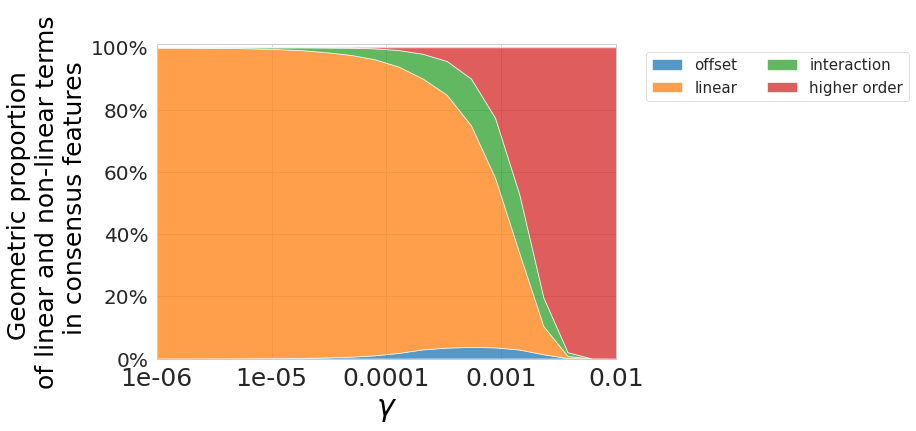

In [9]:
xticks = np.logspace(-6, -2, 5)
yticks = np.linspace(0,1,6)
yticks_labels = ['%s%%'%(int(100*(y))) for y in yticks]

plt.figure(figsize=(13,6))

plt.stackplot(global_contribution_consensus_df.index.astype(float),
              global_contribution_consensus_df.values.T, 
              labels=global_contribution_consensus_df.columns,alpha=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=15, ncol=2)
plt.xscale('log')
plt.xticks(xticks, xticks, fontsize=25)
plt.grid(True)
plt.yticks(yticks, yticks_labels, fontsize=20)
plt.xlim(min(xticks), xticks[-1])
plt.ylim(0,1.01)
plt.ylabel('Geometric proportion \n of linear and non-linear terms \n in consensus features',
           fontsize=25,
           color='black')
plt.xlabel('$\gamma$', fontsize=30, color='black')
plt.tight_layout()

plt.savefig('figures/stacked_figure_contribution_n_pv_%s.png'%(n_pv), dpi=300)
plt.show()

In [21]:
xticks_lines = [
    10**(-5),
    10**(-4.5),
    10**(-4),
    10**(-3.5),
    10**(-3),
    10**(-2.5),
    10**(-2),
]

# xticks_lines_labels = [
#     '  $\gamma_%s$  \n%s'%(i+1, f'{x:.0E}')
#     for i, x in enumerate(xticks_lines)
# ]
xticks_lines_labels = [
    '\n%s'%(f'{x:.0E}')
    for i, x in enumerate(xticks_lines)
]

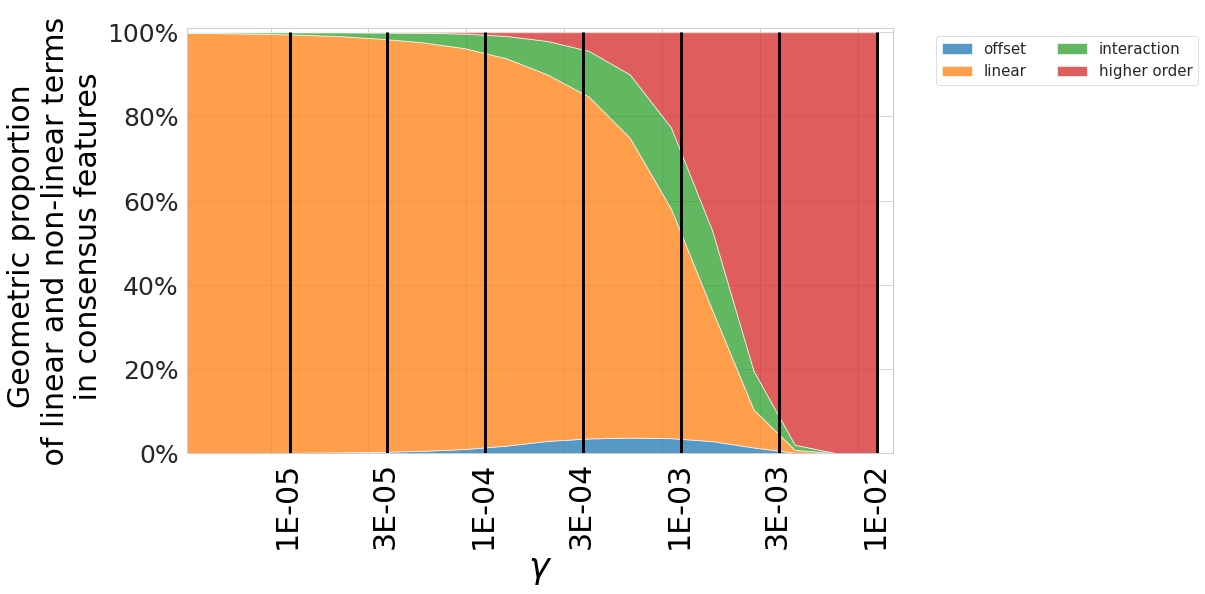

In [42]:
# xticks = np.logspace(-5, -2, 4)
xticks = np.array(xticks_lines)
yticks = np.linspace(0,1,6)
yticks_labels = ['%s%%'%(int(100*(y))) for y in yticks]

plt.figure(figsize=(17,8.2))

plt.stackplot(global_contribution_consensus_df.index.astype(float),
              global_contribution_consensus_df.values.T, 
              labels=global_contribution_consensus_df.columns,alpha=0.75)

for i, (x, x_lab) in enumerate(zip(xticks_lines, xticks_lines_labels)):
    plt.vlines(x, 0, 1, linewidth=3)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=15, ncol=2)
plt.xscale('log')
plt.xticks(0.8*xticks, xticks_lines_labels, fontsize=30, rotation='vertical', color='black')
plt.grid(True)
plt.yticks(yticks, yticks_labels, fontsize=25)
plt.xlim(min(xticks)*.3, xticks[-1]*1.2)
plt.ylim(0,1.01)
plt.ylabel('Geometric proportion \n of linear and non-linear terms \n in consensus features',
           fontsize=30,
           color='black')
plt.xlabel('$\gamma$', fontsize=35, color='black')
plt.tight_layout()

plt.savefig('figures/stacked_figure_contribution_annotated_n_pv_%s.png'%(n_pv), dpi=300)
plt.show()